## Authorization to the DEDL services

In [1]:
from dedllogin import DEDL_auth
import requests
import json
import os
from getpass import getpass
from IPython.display import JSON

username = input("Please input your DESP username or email: ")
password = getpass("Please input your DESP password: ")

#auth = deauth.AuthHandler(DESP_USERNAME, DESP_PASSWORD)
auth = DEDL_auth(username, password)

access_token = auth.get_token()
if access_token is not None:
    print("DEDL/DESP Access Token Obtained Successfully")
else:
    print("Failed to Obtain DEDL/DESP Access Token")

auth_headers = {"Authorization": f"Bearer {access_token}"}

Please input your DESP username or email:  jesper.dejby@ri.se
Please input your DESP password:  ········


DEDL/DESP Access Token Obtained Successfully


## Download data

We are aiming to download the Sentinel-3 OLCI Level 2 WFR dataset described here: https://hda.data.destination-earth.eu/ui/dataset/EO.EUM.DAT.SENTINEL-3.OL_2_WFR___

In [2]:
response_sst = requests.post("https://hda.data.destination-earth.eu/stac/search", headers=auth_headers, json={
    "collections": ["EO.EUM.DAT.SENTINEL-3.OL_2_WFR___"],
    "datetime": "2024-06-02T00:00:00Z/2024-06-03T00:00:00Z",
    'bbox': [10,53,30,66] #latitude and longitude for Baltic Sea
})

In [3]:
from IPython.display import JSON
JSON(response_sst.json())

<IPython.core.display.JSON object>

In [4]:
product_ol2wfr = response_sst.json()["features"][0]
JSON(product_ol2wfr)

<IPython.core.display.JSON object>

### Potential datasets
We download all potential bands that could be useful, brief explanation below:

- Oa6 band which has central wavelength 560 nm - proxy for subsurface bloom of cyanobacteria
- Oa8 band which has central wavelength 665 nm - proxy for surface accumulation of cyanobacteria
- chl_nn band which is the algal pigment concentration in complex waters
- chl_oc4me band which is Algal pigment concentration based on the Ocean Colour for MERIS (OC4Me) algorithm
- par band which is the Photosynthetically Active Radiation (PAR). Inherited from MERIS, instantaneous PAR at the water surface
- geo_coordinates band which contains the latitude/longitude coordinates of the product

In [5]:
download_assets=[
    "Oa06_reflectance.nc",
    "Oa08_reflectance.nc", 
    "chl_nn.nc",
    "chl_oc4me.nc",
    "geo_coordinates.nc",
    "par.nc"
]

In [6]:
from tqdm import tqdm
import time
def download_feature(download_url, filename, auth_headers):
    response = requests.get(download_url, headers=auth_headers)
    total_size = int(response.headers.get("content-length", 0))
    
    print(f"downloading {filename}")
    
    with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
        with open(filename, 'wb') as f:
            for data in response.iter_content(1024):
                progress_bar.update(len(data))
                f.write(data)

In [7]:
for asset in product_ol2wfr["assets"].keys():
    if asset in download_assets:
        url = product_ol2wfr["assets"][asset]["href"]
        name = product_ol2wfr["assets"][asset]["title"]
        download_feature(url, name, auth_headers)

downloading Oa06_reflectance.nc


2.65MB [00:00, 421MB/s]


downloading Oa08_reflectance.nc


2.54MB [00:00, 504MB/s]


downloading chl_nn.nc


2.01MB [00:00, 502MB/s]


downloading chl_oc4me.nc


1.54MB [00:00, 386MB/s]


downloading geo_coordinates.nc


61.8MB [00:00, 554MB/s]


downloading par.nc


716kB [00:00, 490MB/s]


In [5]:
import rioxarray
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import netCDF4 as nc

In [9]:
ds=xr.open_mfdataset(download_assets)

In [10]:
ds

<xarray.Dataset>
Dimensions:               (rows: 4090, columns: 4865)
Dimensions without coordinates: rows, columns
Data variables: (12/13)
    CHL_NN                (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    CHL_NN_unc            (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    CHL_OC4ME             (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    CHL_OC4ME_unc         (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa06_reflectance      (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    Oa06_reflectance_unc  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    ...                    ...
    Oa08_reflectance_unc  (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    PAR                   (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    PAR_unc               (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    altitude              (rows, columns) float32 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    latitude              (rows, columns) float64 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
    longitude             (rows, columns) float64 dask.array<chunksize=(4090, 4865), meta=np.ndarray>
Attributes: (12/17)
    absolute_orbit_number:  31792
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                ops@eumetsat.int
    creation_time:          2024-06-03T16:28:03Z
    ...                     ...
    references:             S3IPF PDS 004.3 - i2r5 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-2 07.04
    start_time:             2024-06-02T08:39:44.349192Z
    stop_time:              2024-06-02T08:42:44.272918Z
    title:                  OLCI Level 2 WATER Product, Neural Net Chlorophyl...

## Plot dataset

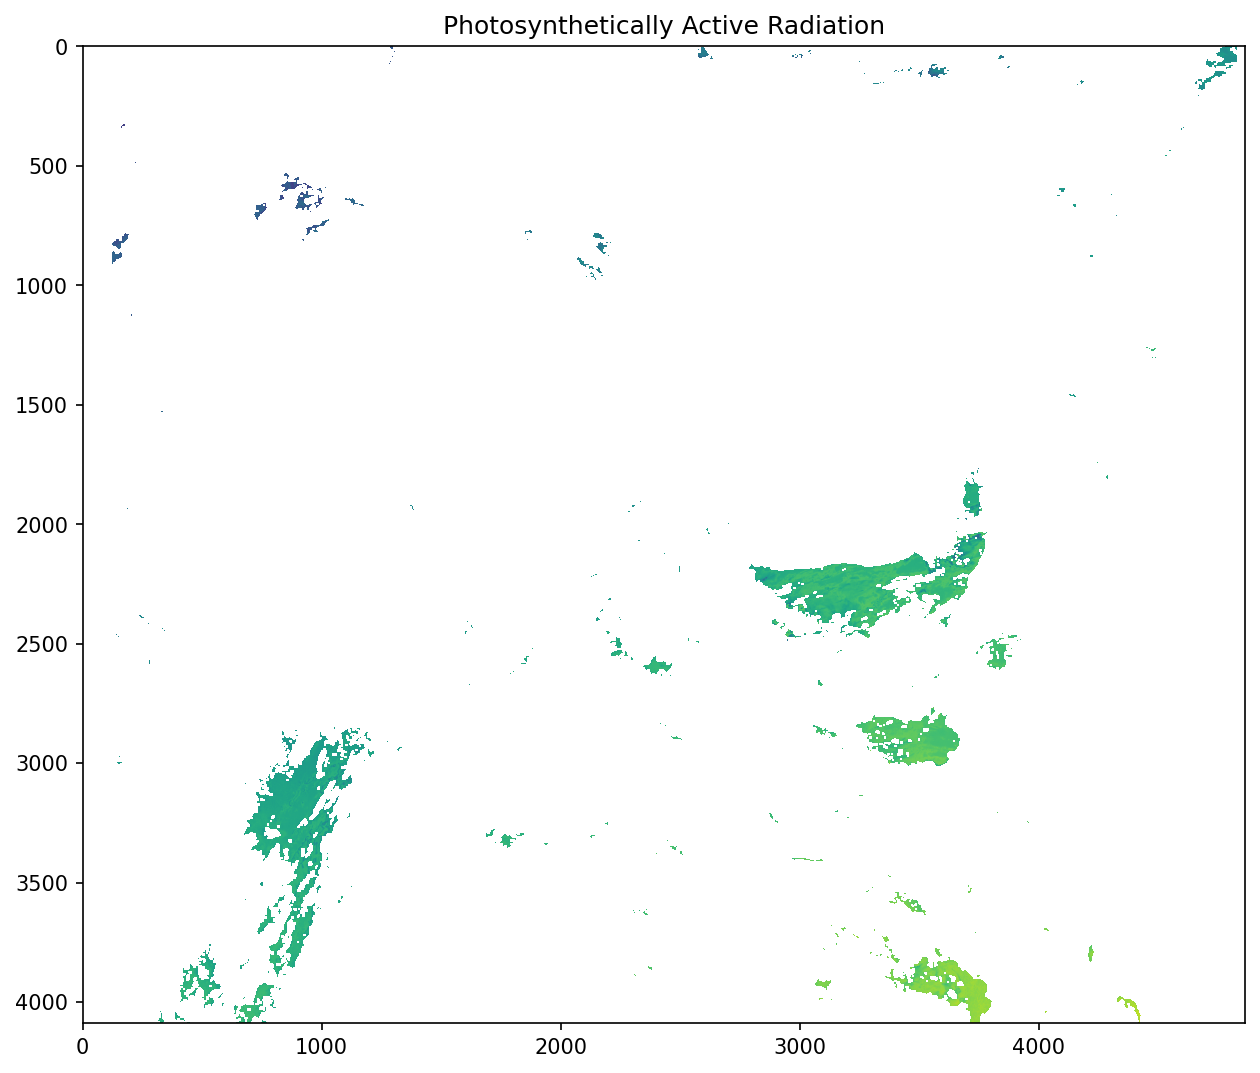

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=150)
ax.imshow(ds["PAR"].values)
ax.title.set_text('Photosynthetically Active Radiation')
plt.show()

In [12]:
ds["PAR"].units

'microeinstein.m-2.s-1'

In [13]:
print(np.nanmin(ds["PAR"].values),np.nanmax(ds["PAR"].values))

1109.0552 1671.2599


### Conclusion

We know that we will use the Oa06 and Oa08 bands since the Swedish Meteorological and Hydrological Institute already have some threshold values on those bands that indicate surface bloom of cyanobacteria. It also seems reasonable to include the PAR. We have a requirement that it should be measured in microenstein per m2. The value range seems reasonable for summer as well.

## Attempt to use GDAL to set a projection and resample the dataset

In [1]:
from osgeo import gdal, osr
from glob import glob

In [2]:
opt=gdal.TranslateOptions(outputType=gdal.GDT_Float32, unscale=True)

### Generate vrt
We create 3 vrt files. One each for latitude and longitude for the XML metadata to point towards. Finally, we create a vrt file for the band we are working with. We want to replace the metadata of this file with the metadata we define ourselves.

In [3]:
gdal.Translate("tst_lat.vrt",
               "NETCDF:geo_coordinates.nc:latitude",
               options=opt
              )
gdal.Translate("tst_lon.vrt",
               "NETCDF:geo_coordinates.nc:longitude",
               options=opt
              )

/opt/conda/envs/python_dedl/lib/python3.11/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fd7d3c546c0> >

In [6]:
ds_par=xr.open_dataset("par.nc")

In [7]:
ds_par

<xarray.Dataset>
Dimensions:  (rows: 4090, columns: 4865)
Dimensions without coordinates: rows, columns
Data variables:
    PAR      (rows, columns) float32 ...
    PAR_unc  (rows, columns) float32 ...
Attributes: (12/17)
    absolute_orbit_number:  31792
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                ops@eumetsat.int
    creation_time:          2024-06-03T16:28:03Z
    ...                     ...
    references:             S3IPF PDS 004.3 - i2r5 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-2 07.04
    start_time:             2024-06-02T08:39:44.349192Z
    stop_time:              2024-06-02T08:42:44.272918Z
    title:                  OLCI Level 2 WATER Product, Photosynthetically Ac...

In [8]:
gdal.Translate("tst_par.vrt",
               "NETCDF:par.nc:PAR",
               options=opt
              )

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fd7d3c54630> >

In [9]:
import lxml.etree

### Replace metadata
XML metadata that let's GDAL know about the projection and where the latitude and longitude can be found.

In [10]:
geocoding = lxml.etree.fromstring(f"""
    <metadata domain="GEOLOCATION">
      <mdi key="SRS">
        GEOGCS["WGS 84",
            DATUM["WGS_1984",
                SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],
                AUTHORITY["EPSG","6326"]],
            PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],
            UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],
            AUTHORITY["EPSG","4326"]]
      </mdi>
      <mdi key="X_DATASET">tst_lon.vrt</mdi>
      <mdi key="X_BAND">1</mdi>
      <mdi key="Y_DATASET">tst_lat.vrt</mdi>
      <mdi key="Y_BAND">1</mdi>
      <mdi key="PIXEL_OFFSET">0</mdi>
      <mdi key="LINE_OFFSET">0</mdi>
      <mdi key="PIXEL_STEP">1</mdi>
      <mdi key="LINE_STEP">1</mdi>
    </metadata>
  """)

In [11]:
with open("tst_par.vrt") as f:
    root = lxml.etree.fromstring(f.read())
for metadata in root.xpath("//Metadata"):
    metadata.getparent().remove(metadata)
root.insert(0, geocoding)
with open("tst_par.vrt", "wb") as f:
    f.write(lxml.etree.tostring(root))

### Resample and clip

Resample using cubic resampling. Clip the raster to the output region we specify in outputBounds.  We force the use of the Geolocation Array specified in the metadata above.

In [26]:
warp_opt=gdal.WarpOptions(
    geoloc=True,
    resampleAlg="cubic",
    format="COG",
    creationOptions={'COMPRESS':'DEFLATE'},
    dstSRS="EPSG:4326",
    # Approx 300x300m in pixel size
    xRes=0.0027,
    yRes=0.0027,
    outputBounds=[10,53,30,66],
    cropToCutline=True)

In [27]:
gdal.Warp("par_warped.tif","tst_par.vrt", options=warp_opt)

ERROR 1: Too many points (529 out of 529) failed to transform, unable to compute output bounds.
Warning 1: Unable to compute source region for output window 0,2304,3584,2511, skipping.
ERROR 1: Too many points (529 out of 529) failed to transform, unable to compute output bounds.
Warning 1: Unable to compute source region for output window 3584,2304,3823,2511, skipping.


<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fd691edbde0> >

In [28]:
import rasterio
from rasterio import plot
im = rasterio.open("par_warped.tif")

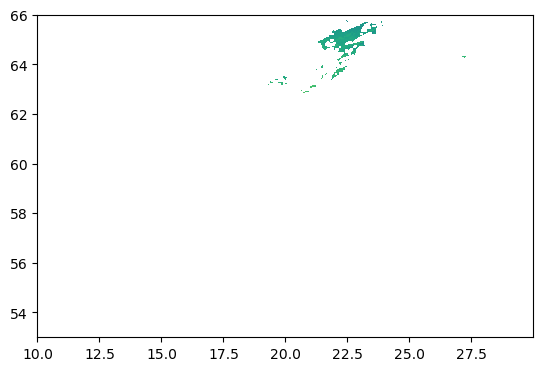

<Axes: >

In [29]:
plot.show(im)

### Conclusion

This might be correct but not sure how to verify it. After discussion with EUMETSAT we decided to go ahead and use Satpy to set projection and resample the dataset as there was ready available examples that could provided by them. 